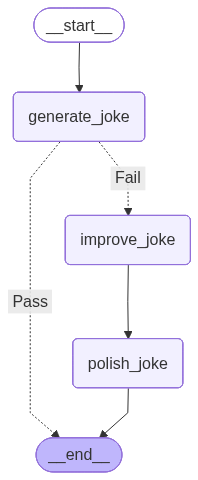

Initial joke:
Why did the cat sit on the computer?  
Because it wanted to keep an eye on the mouse!

--- --- ---

Final joke:
Why did the cat sit on the computer?  
Because it wanted to keep an eye on the mouse!


In [1]:
from langchain_openai import ChatOpenAI

from dotenv import load_dotenv
load_dotenv()

llm = ChatOpenAI(
    model="gpt-4.1-mini",  # fast + cheap for learning
    temperature=0.7
)

from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Final joke:")
    print(state["joke"])

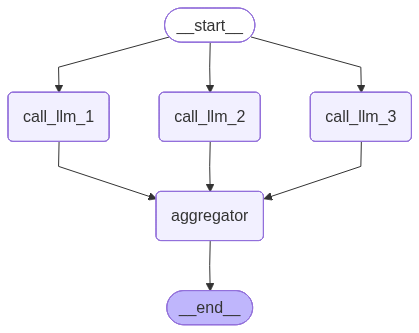

Here's a story, joke, and poem about cats!

STORY:
Once upon a time in a quiet village nestled between rolling hills, there lived a curious cat named Luna. Luna was no ordinary cat; she had a sleek silver coat that shimmered under the moonlight and eyes as green as emeralds. Every night, while the villagers slept, Luna would embark on adventures through the village and the surrounding forests.

One evening, as the full moon rose high, Luna noticed a faint, flickering light deep within the woods. Intrigued, she padded silently toward it, her whiskers twitching with excitement. The light led her to a hidden glade where an ancient oak tree stood, its branches sparkling with tiny glowing orbs.

As Luna approached, a soft voice whispered, "Welcome, Luna. We've been waiting for you." From behind the tree emerged a circle of cats, each with coats of different colors and patterns, their eyes glowing gently in the moonlight. They were the Guardians of the Night, mystical cats who protected the 

In [2]:
from langchain_openai import ChatOpenAI

from dotenv import load_dotenv
load_dotenv()

llm = ChatOpenAI(
    model="gpt-4.1-mini",  # fast + cheap for learning
    temperature=0.7
)

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke, story and poem into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

In [3]:
from langchain_openai import ChatOpenAI

from dotenv import load_dotenv
load_dotenv()

llm = ChatOpenAI(
    model="gpt-4.1-mini",  # fast + cheap for learning
    temperature=0.7
)

from typing_extensions import Literal
from langchain.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

NameError: name 'BaseModel' is not defined

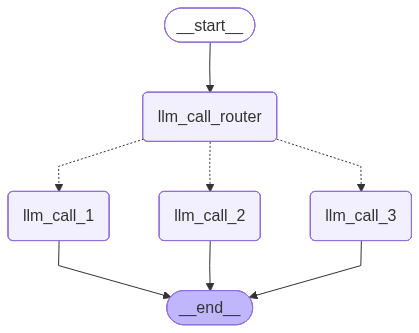

/Users/chetansirohi/Desktop/Revops/.venv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=Route(step='joke'), input_type=Route])
  return self.__pydantic_serializer__.to_python(


Why did the cat sit on the computer?

Because it wanted to keep an eye on the mouse!


In [4]:
from langchain_openai import ChatOpenAI

from dotenv import load_dotenv
load_dotenv()

llm = ChatOpenAI(
    model="gpt-4.1-mini",  # fast + cheap for learning
    temperature=0.7
)

from typing_extensions import Literal
from langchain.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field
from typing_extensions import Literal


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        description="The next step in the routing process"
    )



# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])


In [5]:
from langchain_openai import ChatOpenAI

from dotenv import load_dotenv
load_dotenv()

llm = ChatOpenAI(
    model="gpt-4.1-mini",  # fast + cheap for learning
    temperature=0.7
)

from langgraph.types import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

NameError: name 'Section' is not defined

In [6]:
from dotenv import load_dotenv
load_dotenv()

import operator
from typing import List
from typing_extensions import TypedDict, Annotated

from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain.messages import SystemMessage, HumanMessage

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

from IPython.display import Image, display, Markdown


In [7]:
llm = ChatOpenAI(
    model="gpt-4.1-mini",
    temperature=0.7
)


In [8]:
class Section(BaseModel):
    name: str = Field(description="Title of the report section")
    description: str = Field(description="What this section should cover")


class Sections(BaseModel):
    sections: List[Section]


In [9]:
planner = llm.with_structured_output(Sections)


In [10]:
class State(TypedDict):
    topic: str
    sections: List[Section]
    completed_sections: Annotated[list, operator.add]
    final_report: str


class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


In [11]:
def orchestrator(state: State):
    """Generates a plan for the report"""
    plan = planner.invoke(
        [
            SystemMessage(content="Generate a structured outline for the report."),
            HumanMessage(content=f"Report topic: {state['topic']}")
        ]
    )
    return {"sections": plan.sections}

def llm_call(state: WorkerState):
    """Worker writes a single section"""
    response = llm.invoke(
        [
            SystemMessage(
                content=(
                    "Write a detailed report section using markdown. "
                    "Do not include a title header."
                )
            ),
            HumanMessage(
                content=(
                    f"Section name: {state['section'].name}\n"
                    f"Description: {state['section'].description}"
                )
            ),
        ]
    )
    return {"completed_sections": [response.content]}

def synthesizer(state: State):
    """Combine all sections into final report"""
    report = "\n\n---\n\n".join(state["completed_sections"])
    return {"final_report": report}



In [12]:
def assign_workers(state: State):
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


In [13]:
builder = StateGraph(State)

builder.add_node("orchestrator", orchestrator)
builder.add_node("llm_call", llm_call)
builder.add_node("synthesizer", synthesizer)

builder.add_edge(START, "orchestrator")
builder.add_conditional_edges(
    "orchestrator",
    assign_workers,
    ["llm_call"]
)
builder.add_edge("llm_call", "synthesizer")
builder.add_edge("synthesizer", END)

orchestrator_worker = builder.compile()


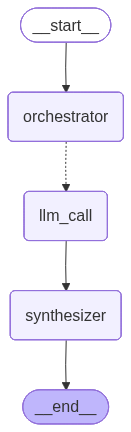

/Users/chetansirohi/Desktop/Revops/.venv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=Sections(sections=[Sectio...r the field of LLMs.')]), input_type=Sections])
  return self.__pydantic_serializer__.to_python(


Large Language Models (LLMs) are advanced artificial intelligence systems designed to understand, generate, and manipulate human language at scale. These models are typically built using deep learning architectures such as transformers, which enable them to process vast amounts of textual data and learn complex patterns in language. LLMs have demonstrated remarkable capabilities across various natural language processing tasks, including text generation, translation, summarization, and question answering, making them integral to modern AI applications.

A critical aspect of LLM development is the understanding and application of scaling laws. Scaling laws describe how changes in model size, the amount of training data, and computational resources affect the performance and capabilities of language models. Empirical research has shown that increasing the number of parameters, training data, and compute leads to predictable improvements in model accuracy and generalization. These laws provide valuable guidance for efficiently allocating resources during model training, helping researchers and engineers design models that maximize performance while managing costs.

The importance of scaling laws lies in their ability to inform the trade-offs involved in developing LLMs. By quantifying the relationship between scale and performance, scaling laws enable more informed decisions about when to invest in larger models or more data, and when diminishing returns might occur. This understanding is essential for advancing LLM capabilities, optimizing training strategies, and ultimately deploying more effective and reliable language-based AI systems.

---

## Background and Theory of Scaling Laws

Scaling laws describe how the performance of machine learning models, particularly large language models (LLMs), changes as a function of key variables such as model size, dataset size, and the amount of computational resources used during training. Understanding these relationships is crucial for optimizing model design and training strategies to achieve better performance efficiently.

### Theoretical Foundations

The concept of scaling laws in machine learning emerged from empirical observations that model performance improves predictably when increasing certain factors. These laws are often expressed through power-law relationships, where performance metrics (e.g., loss, accuracy) scale as a function of model size, training dataset size, or compute budget raised to some exponent.

Mathematically, a general scaling law can be represented as:

\[
L(N, D, C) = a \cdot N^{-\alpha} + b \cdot D^{-\beta} + c \cdot C^{-\gamma} + L_0
\]

where:  
- \( L \) is the loss or error metric,  
- \( N \) is the number of model parameters (model size),  
- \( D \) is the size of the training dataset,  
- \( C \) is the amount of compute used during training,  
- \( a, b, c \) are constants,  
- \( \alpha, \beta, \gamma \) are scaling exponents typically between 0 and 1,  
- \( L_0 \) is the irreducible loss floor.

### Impact of Model Size

Model size, usually measured by the number of parameters, has a significant effect on performance. Larger models have greater capacity to represent complex functions and patterns in data. Empirical studies show that increasing model size reduces loss approximately following a power-law decay, meaning that performance gains diminish as models become extremely large, but still improve.

However, simply increasing model size without proportional increases in data or compute can lead to overfitting or inefficient training. This highlights the importance of balanced scaling.

### Impact of Data Size

The size of the training dataset directly influences the model’s ability to generalize. Larger datasets provide more diverse examples, enabling models to learn richer representations. Scaling laws demonstrate that model performance improves as a power-law function of dataset size, but with diminishing returns at very large data volumes.

Crucially, data scaling must be matched with model capacity — too little data for a large model leads to undertraining, while too much data for a small model may not be fully exploited.

### Impact of Compute Resources

Compute resources encompass the total amount of processing power and training time allocated, often measured in floating-point operations (FLOPs). Scaling laws reveal that performance improves predictably with increased compute, as more iterations and larger batch sizes allow models to better optimize parameters.

The compute budget also constrains feasible combinations of model size and dataset size. Efficient allocation of compute between model scaling and data scaling is key to maximizing returns.

### Interplay Between Model Size, Data, and Compute

Recent theoretical and empirical work emphasizes the interconnectedness of these three factors. Optimal training requires jointly scaling model size, data size, and compute in a balanced manner to avoid bottlenecks. For example, increasing model size without increasing data or compute leads to suboptimal performance, while increasing data or compute without a sufficiently large model limits learning capacity.

Scaling laws provide practical guidelines for choosing these parameters to achieve the best trade-offs in performance, cost, and training time.

---

In summary, the theoretical foundations of scaling laws in LLMs illustrate how model size, data size, and compute resources interact through power-law relationships to influence performance. These insights guide efficient model development and help predict returns from scaling efforts.

---

## Empirical Studies and Key Findings

Empirical research has played a crucial role in validating and refining scaling laws for large language models (LLMs). These scaling laws, which describe how model performance improves as a function of model size, dataset size, and computational resources, have been substantiated through extensive experiments and analyses across multiple studies.

### Early Empirical Validation

One of the foundational empirical studies was conducted by Kaplan et al. (2020), who systematically trained transformer-based language models ranging from millions to billions of parameters. Their experiments demonstrated that loss decreases predictably as a power-law function of model size, dataset size, and training compute. This provided strong quantitative evidence that scaling laws can reliably predict the performance of LLMs, enabling researchers to anticipate returns on investment in larger models and datasets.

### Refinements Through Subsequent Research

Following Kaplan et al., several studies refined these initial findings:

- **Henighan et al. (2020)** expanded the scope by including more model architectures and training regimes, confirming that scaling laws hold across variations in hyperparameters and training setups. They also identified subtle deviations from pure power-law behavior at extreme scales, prompting further investigation into optimal scaling strategies.

- **Chinchilla (2022)** introduced the concept that optimal performance is not merely a function of increasing model size but requires proportional scaling of dataset size. Their empirical results showed that many large models were undertrained relative to their parameter count, leading to the proposal of a more balanced scaling rule between model parameters and training tokens.

### Experimental Evidence from Industry-scale Models

Industry experiments, most notably from OpenAI, Google, and DeepMind, have provided large-scale validation of scaling laws:

- OpenAI's GPT series has consistently demonstrated improvements aligned with scaling predictions. For example, the transition from GPT-2 to GPT-3 involved increasing parameters by two orders of magnitude while scaling dataset size, yielding substantial performance gains across diverse NLP benchmarks.

- DeepMind's work on the Gopher model and subsequent research on Chinchilla reaffirmed the importance of balancing compute between model size and training data, leading to more compute-efficient model designs.

### Key Findings

- **Predictability of Performance:** Scaling laws enable accurate forecasting of model performance given known computational budgets, aiding in resource allocation and experimental design.

- **Compute-Optimal Training:** Empirical evidence supports the existence of an optimal trade-off between model size and training data quantity, maximizing performance per unit of compute.

- **Limitations at Extreme Scales:** Deviations from simple scaling laws emerge at very large model sizes or dataset scales, hinting at the need for new architectures or training techniques beyond current paradigms.

- **Generalization Across Architectures:** While initially formulated for transformer-based LLMs, scaling laws have shown applicability to other architectures, although specific coefficients and exponents may vary.

### Conclusion

Empirical studies have not only confirmed the foundational scaling laws but also enriched them with nuanced insights about optimal training regimes and limitations. These findings continue to guide the development of next-generation LLMs, underlining the importance of rigorous experimentation in advancing the field.

---

## Implications for Model Training and Deployment

Scaling laws, which describe predictable relationships between model size, dataset size, compute resources, and performance, have significant implications for the training strategies, resource allocation, and deployment of large language models (LLMs). Understanding these laws enables more informed decision-making throughout the lifecycle of LLM development.

### Training Strategies

1. **Optimal Model and Dataset Sizing**  
   Scaling laws indicate that performance improvements can be systematically achieved by increasing model parameters, dataset size, or training compute. This insight guides practitioners to balance these factors rather than arbitrarily scaling one dimension. For example, simply enlarging the model without proportionally increasing the dataset or compute can lead to diminishing returns or underfitting.

2. **Efficient Use of Compute Resources**  
   By analyzing scaling curves, training can be planned to reach the "optimal frontier," where the marginal gain per unit of compute is maximized. This helps avoid overtraining or undertraining—both of which waste resources. It also informs decisions on whether to invest in longer training with smaller models or shorter training with larger models.

3. **Curriculum and Transfer Learning**  
   Knowledge of scaling behavior supports strategies such as curriculum learning, where models are trained progressively on data of increasing complexity. Similarly, it informs transfer learning and fine-tuning approaches by highlighting the scaling benefits of starting from pretrained models of appropriate size.

### Resource Allocation

1. **Budgeting and Infrastructure Planning**  
   Scaling laws provide quantitative estimates of the compute and data requirements needed to achieve target performance levels. This enables precise budgeting for hardware acquisition, cloud usage, and data curation efforts.

2. **Trade-offs Between Model Size and Training Time**  
   Organizations must weigh the cost of training very large models against the expected performance gains. Scaling laws help identify points of diminishing returns where additional investment in scale may not justify the incremental improvement, guiding more cost-effective resource distribution.

3. **Energy and Environmental Considerations**  
   Since training large LLMs consumes substantial energy, understanding scaling laws can help minimize environmental impact by optimizing training durations and model sizes, thereby reducing unnecessary computational overhead.

### Deployment Considerations

1. **Model Size vs. Latency and Throughput**  
   Scaling laws imply that larger models typically yield better accuracy but require more memory and computational power during inference. Deployment strategies must balance these factors, potentially leveraging model compression, distillation, or adaptive inference to maintain responsiveness.

2. **Customization and Adaptability**  
   Insights from scaling laws encourage modular deployment approaches, where base large models are fine-tuned or adapted to specific tasks or domains, maximizing utility while minimizing the need for retraining from scratch.

3. **Scalability and Future-proofing**  
   Understanding the trajectory of scaling benefits allows organizations to plan deployment infrastructures that can accommodate future, larger models, ensuring scalability and longevity of AI services.

---

In summary, scaling laws provide a foundational framework that informs every stage of LLM development—from initial training strategy design through resource management to deployment optimization. Leveraging these insights leads to more efficient, cost-effective, and sustainable use of large language models in practice.

---

## Challenges and Limitations

Applying scaling laws to the development of large language models (LLMs) has significantly advanced our understanding of how model performance improves with increased data, parameters, and compute. However, several challenges and limitations persist that complicate the straightforward use of these laws.

### 1. Empirical Nature and Generalization Limits
Scaling laws are primarily derived from empirical observations based on specific model architectures, training datasets, and compute budgets. This reliance on empirical data means that the laws may not generalize well across different types of models or emerging architectures. For instance, scaling laws established on transformer-based models may not hold for alternative architectures or hybrid models incorporating symbolic reasoning.

### 2. Data Quality and Distribution Biases
Scaling laws typically assume that data quality and distribution remain consistent as dataset size increases. In reality, as datasets grow, they often include noisier or less relevant data, which can degrade model performance or lead to overfitting on irrelevant patterns. Moreover, biases present in the data can be amplified rather than mitigated by larger datasets, causing fairness and ethical concerns that scaling laws do not explicitly address.

### 3. Compute and Resource Constraints
While scaling laws suggest continuous performance improvements with more compute, practical constraints limit how much compute can be applied. The exponential growth in required compute and energy consumption raises sustainability and accessibility issues. Smaller organizations or research groups may be unable to follow scaling trends, limiting innovation to well-funded entities.

### 4. Diminishing Returns and Saturation Effects
Although early scaling trends showed predictable improvements, recent research indicates diminishing returns as models become extremely large. Performance gains may plateau or improve at slower rates, and scaling laws may fail to capture these saturation effects accurately. This complicates decisions about resource allocation, as the cost-benefit tradeoff becomes less favorable.

### 5. Potential for Overfitting and Memorization
Scaling laws often focus on aggregate performance metrics such as perplexity or accuracy but may overlook qualitative aspects like overfitting or memorization of training data. As models scale up, the risk that they memorize rare or sensitive data increases, raising privacy and security concerns that are not addressed by scaling laws alone.

### 6. Lack of Theoretical Foundations
Currently, scaling laws are largely phenomenological, lacking a comprehensive theoretical framework that explains why performance scales as observed. This limits predictive power when extrapolating beyond observed scales or applying laws to novel domains, architectures, or modalities.

### 7. Ethical and Societal Implications
Scaling laws emphasize performance improvements but do not incorporate ethical considerations directly. Larger models may perpetuate or exacerbate societal biases embedded in training data, and the environmental impact of training large models is substantial. These factors represent important limitations that must be addressed alongside technical scaling challenges.

---

In summary, while scaling laws provide valuable insights into the development of LLMs, their application is constrained by empirical limitations, data biases, resource demands, diminishing returns, and broader ethical concerns. Addressing these challenges requires complementary approaches including improved data curation, architectural innovations, theoretical advances, and responsible AI practices.

---

## Future Directions and Research Opportunities

The study of scaling laws in large language models (LLMs) has opened numerous pathways for advancing both theoretical understanding and practical capabilities. As LLMs continue to grow in size and complexity, several emerging trends and research opportunities stand out as promising areas for future exploration.

### Emerging Trends

1. **Multimodal Scaling Laws**  
   While much of the current work on scaling laws focuses on text-based models, there is increasing interest in understanding how these laws extend to multimodal models that integrate text, images, audio, and video. Future research could investigate whether similar power-law behaviors hold when scaling parameters, data, and compute in multimodal architectures, and how cross-modal interactions influence scaling dynamics.

2. **Efficiency and Sustainability**  
   The rapid growth of model sizes raises concerns about computational costs and environmental impact. There is a growing trend toward developing scaling laws that incorporate energy efficiency and carbon footprint considerations. Research into more efficient training paradigms, such as sparse models, quantization, and knowledge distillation, may lead to new scaling laws that balance performance gains with sustainability.

3. **Fine-tuning and Transfer Learning**  
   Most scaling laws focus on pretraining from scratch, but fine-tuning on downstream tasks is critical for practical applications. Emerging work aims to characterize how scaling laws apply during fine-tuning and transfer learning, potentially revealing new regimes or modified laws that govern performance improvements in these contexts.

### Potential Improvements

1. **Data Quality and Diversity Metrics**  
   Current scaling laws primarily quantify training data volume but often overlook data quality and diversity factors. Developing metrics to measure and incorporate these aspects could refine scaling predictions, enabling more targeted data collection strategies that maximize model performance per data unit.

2. **Architectural Innovations**  
   As transformer-based architectures dominate current LLMs, future research might uncover alternative or hybrid architectures with different scaling behaviors. Investigating how architectural changes affect scaling laws could lead to models that scale more efficiently or exhibit superior generalization properties.

3. **Robustness and Safety Scaling**  
   Understanding how robustness to adversarial inputs, biases, and model safety scales with size and data is an open challenge. Future studies could establish scaling relationships for these critical attributes, guiding the development of safer and more reliable LLMs.

### Areas for Future Research

1. **Theoretical Foundations**  
   Despite empirical successes, the theoretical underpinnings of scaling laws remain partially understood. Research focusing on formalizing the mathematical principles behind observed scaling behaviors could provide deeper insights, enabling predictive modeling of LLM capabilities and limitations.

2. **Scaling Laws for Emergent Abilities**  
   Recent observations suggest that certain complex capabilities appear abruptly as models scale, often referred to as emergent abilities. Investigating the conditions and mechanisms behind these phenomena could lead to new scaling frameworks that account for nonlinear performance jumps.

3. **Cross-Domain Generalization**  
   Exploring how scaling laws influence a model’s ability to generalize across different domains, languages, or tasks remains largely unexplored. Future work could analyze scaling effects on transferability and adaptability, informing the design of more versatile LLMs.

4. **Human-in-the-Loop and Interactive Scaling**  
   Integrating human feedback and interaction into the training loop presents new dimensions for scaling. Research could focus on how scaling laws evolve when models learn continuously from human inputs, potentially enhancing alignment and personalization.

In summary, the ongoing exploration of scaling laws offers a rich landscape for advancing LLM research. By addressing these emerging trends, refining current models, and tackling open questions, the field can move toward more powerful, efficient, and responsible language technologies.

---

The report has examined several critical aspects of large language models (LLMs), including their architecture, training methodologies, performance benchmarks, and practical applications. Key points highlighted include the importance of scalable transformer-based architectures in achieving state-of-the-art language understanding and generation capabilities. The discussion on training strategies emphasized the role of vast and diverse datasets combined with advanced optimization techniques to enhance model generalization and reduce biases.

Furthermore, the evaluation metrics and benchmarks reviewed provide a comprehensive framework for assessing LLM performance across various natural language processing tasks. The report also explored emerging trends such as fine-tuning with domain-specific data and leveraging few-shot learning, which significantly expand the versatility and adaptability of LLMs in real-world scenarios.

The significance of these findings lies in their contribution to advancing the development and deployment of LLMs, enabling more accurate, efficient, and ethical AI systems. By addressing challenges related to model interpretability, computational costs, and ethical considerations, the report underlines the ongoing efforts needed to harness the full potential of LLMs responsibly. Overall, these insights offer valuable guidance for researchers, practitioners, and stakeholders aiming to push the boundaries of language AI technologies.

In [14]:
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

state = orchestrator_worker.invoke(
    {"topic": "Create a report on LLM scaling laws"}
)

Markdown(state["final_report"])


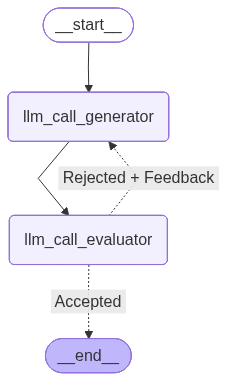

Why did the cat sit on the computer?

Because it wanted to keep an eye on the mouse!


/Users/chetansirohi/Desktop/Revops/.venv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=Feedback(grade='funny', feedback=''), input_type=Feedback])
  return self.__pydantic_serializer__.to_python(


In [15]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

In [16]:
from langchain.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

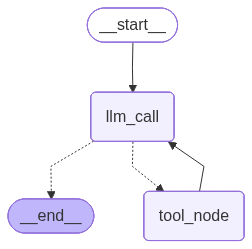

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_mRyV1wHZw9DIsha7t29EEdQy)
 Call ID: call_mRyV1wHZw9DIsha7t29EEdQy
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

3 plus 4 equals 7.


In [17]:
from langgraph.graph import MessagesState
from langchain.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

In [18]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.runnables import RunnableConfig
from typing import Annotated
from typing_extensions import TypedDict
from operator import add

class State(TypedDict):
    foo: str
    bar: Annotated[list[str], add]

def node_a(state: State):
    return {"foo": "a", "bar": ["a"]}

def node_b(state: State):
    return {"foo": "b", "bar": ["b"]}


workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

config: RunnableConfig = {"configurable": {"thread_id": "1"}}
graph.invoke({"foo": "", "bar":[]}, config)

{'foo': 'b', 'bar': ['a', 'b']}

In [19]:
# get the latest state snapshot
config = {"configurable": {"thread_id": "1"}}
graph.get_state(config)

# get a state snapshot for a specific checkpoint_id
config = {"configurable": {"thread_id": "1", "checkpoint_id": "1ef663ba-28fe-6528-8002-5a559208592c"}}
graph.get_state(config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1ef663ba-28fe-6528-8002-5a559208592c'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())